[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import six
import yaml

from collections import Counter, OrderedDict
from joblib import cpu_count, delayed, Parallel
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels, dpi=240, filled=False, ret_image=False):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        image = draw_contours(image, masks[i], labels[i], filled)
    if ret_image:
        return image
    else:
        display_image(image, dpi=dpi)

def display_fluorescence(fluorescence, masks, labels, ret_image=False):
    image = cv2.cvtColor(scale_image(fluorescence), cv2.COLOR_GRAY2RGB)
    if fluorescence.max() == 1:  # if binary image
        sc, fc = {}, {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            image = draw_contours(image, combined_mask & fluorescence, k, filled=True)
            sc[k] = sum(combined_mask.flatten())
            fc[k] = sum((combined_mask & fluorescence).flatten())
        for k in sc:
            print("Class %s (%s): %i/%i (%.2f%%)" %
                  (k, colormap.colors[k], fc[k], sc[k], fc[k]*100/sc[k]))
    else:
        fig, axs = plt.subplots(1, len(np.unique(labels)), figsize=(18,5))
        intensities = scale_image(image_fluorescent, 100)
        fc = {}
        for k in np.unique(labels):
            combined_mask = np.bitwise_or.reduce(masks[np.where(labels==k)], axis=0)
            image = draw_contours(image, combined_mask, k)
            axs[k].hist(intensities.flatten()[np.nonzero(combined_mask.flatten())],
                     bins=range(100), color = colormap.colors[k])
            axs[k].set_title("Class %i" % k)
            axs[k].set_xlim([0,100])
    if ret_image:
        return image
    else:
        display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = TSNE(learning_rate='auto', init='pca', random_state=0).fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def draw_contours(image, mask, color_label, filled=False):
    color = np.array(matplotlib.colors.to_rgb(colormap.colors[color_label]))*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    thickness = -1 if filled else 1
    return cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=thickness)

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    # POSSIBLE BUG, VERIFY THAT from_dict DOESN'T INFER WRONG TYPES
    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, param_path, verbosity=0):
    with open(param_path, 'r') as f:
        param_file = yaml.load(f, Loader=yaml.FullLoader)
        mode = param_file['mode']
        params = param_file['params']

    if verbosity:
        print("Using mode '%s'." % mode)
    
    if verbosity and params.get('clipLimit'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    # We are also deliberately not sharpening here
    if params.get('canny_unmasking'):
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, *params.get('canny_unmasking'))
        canny_filled = apply_imfill(apply_closure(canny, 5))
        
    ### IMAGE PREPROCESSING ###
    
    if params.get('invert_image'):
        image = 255 - image

    if params.get('denoise_pre'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params.get('contrast'):
        if verbosity:
            print(("Enhancing contrast by factor of %.2f, with "
                   "offset=%s and preserve_background=%s.") %
                  (params['contrast'], params['offset'], params['preserve_background']))
        image = apply_contrast(image, params['contrast'],
                               params['offset'], params['preserve_background'])
    
    if params.get('clipLimit'):
        if verbosity:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params.get('denoise_post'):
        if verbosity:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])

    if verbosity and params.get('clipLimit'):
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])
    
    ### IMAGE BINARIZATION ###
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbosity:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbosity:
            print("Applying Canny with thresholds %i and %i." %
                  (params['canny_thresh1'], params['canny_thresh2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['canny_thresh1'], params['canny_thresh2'])
    elif mode == "edge_sobel":
        if verbosity:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbosity:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbosity:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_manual":
        if verbosity:
            print("Manually thresholding on values >=%i." % params['manual_threshold'])
        binarized = np.uint8(image >= params['manual_threshold'])
    elif mode == "thresh_otsu":
        if verbosity:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None

    ### IMAGE POSTPROCESSING ###
    
    if params.get('canny_unmasking'):
        if verbosity:
            print("Unmasking areas without edges using Canny%s:" % params.get('canny_unmasking'))
        binarized = binarized & canny_filled  # POSSIBLE BUG: CHECK IF CANNY_FILLED IS BINARY
    
    if params.get('border_removal'):
        if verbosity:
            print("Removing border of %i pixels." % params['border_removal'])
        binarized[:params['border_removal'], :] = 0
        binarized[:, :params['border_removal']] = 0
        binarized[-params['border_removal']:, :] = 0
        binarized[:, -params['border_removal']:] = 0
        
    if params.get('closure_ks'):
        if verbosity:
            print("Closing with kernel size of %i." % params['closure_ks'])
        filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    else:
        filled = apply_imfill(binarized)

    if params.get('size_thresh'):
        if verbosity:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(filled, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                filled = filled * (1 - np.uint8(labelled == i))

    if verbosity >= 2:
        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

## Read in image file

In [4]:
image_stack = cv2.imreadmulti('source_images/suspension_colour.tiff',
                              flags=cv2.IMREAD_GRAYSCALE)[1]

# Extract mask using grayscale image

Using mode 'thresh_adaptive'.
Denoising with intensity 3.
Applying adaptive thresholding with kernel size of 151 and C=8.
Unmasking areas without edges using Canny[130, 180]:
Removing border of 2 pixels.
Closing with kernel size of 8.
Unmasking regions smaller than 250 pixels.


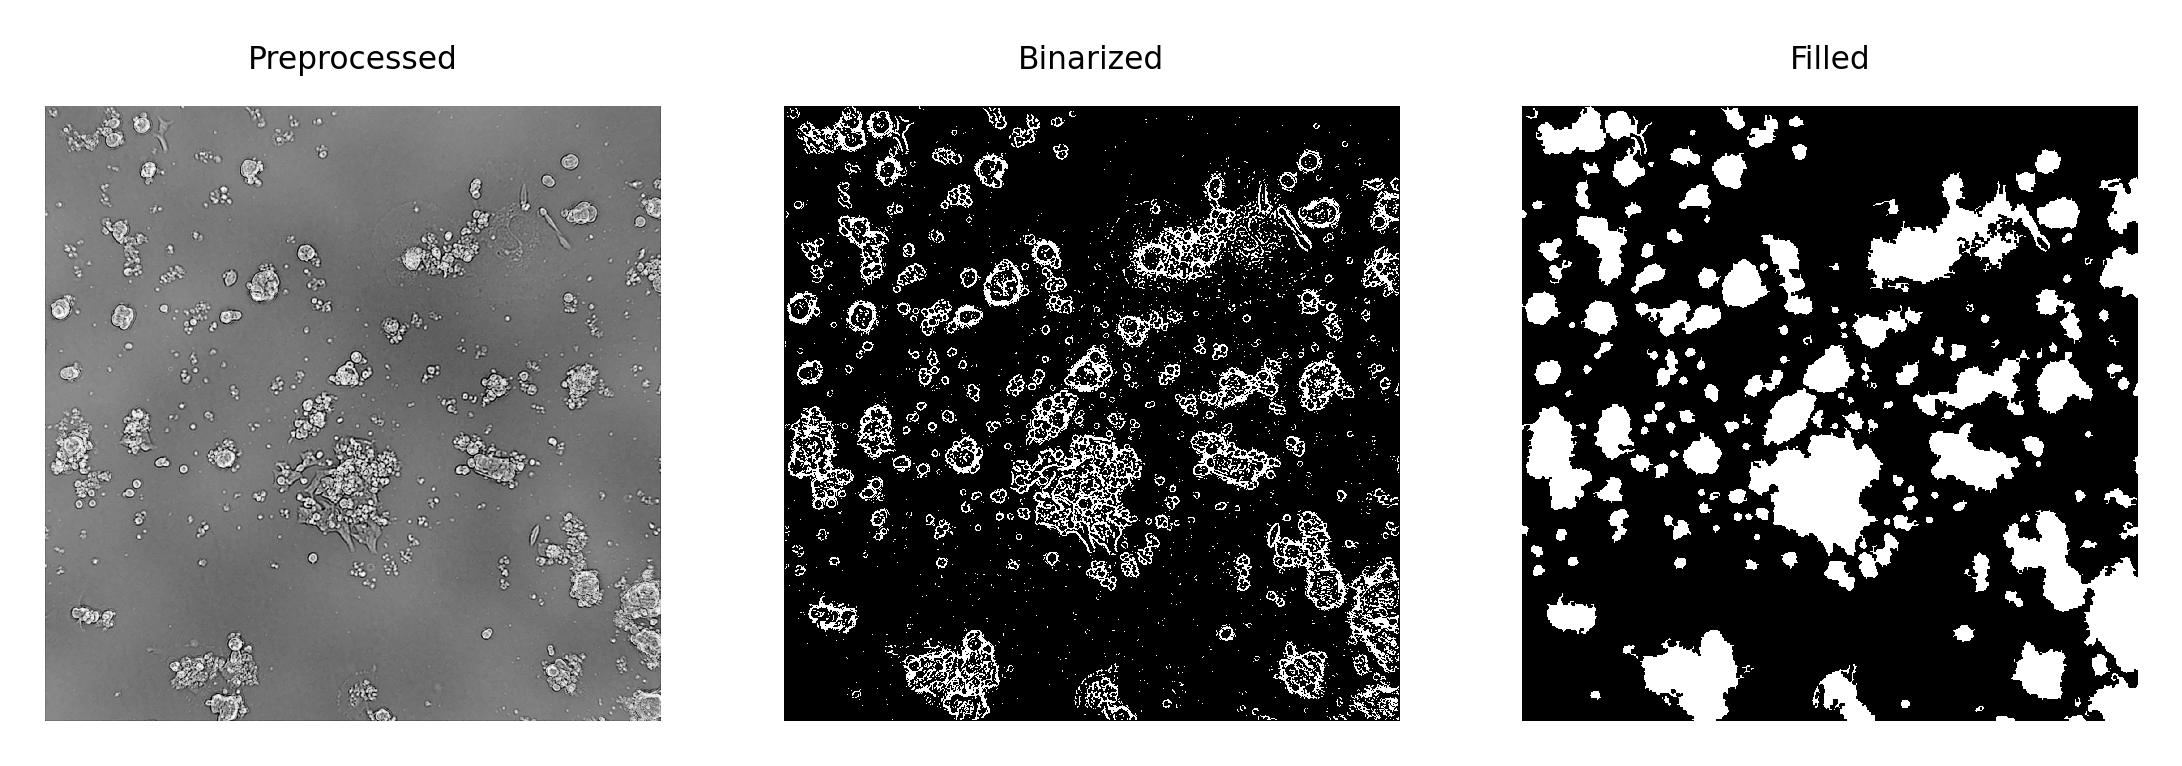

In [5]:
image_gray = scale_image(image_stack[1])
mask_image = get_mask_image(image_gray, 'params_gray_mask.yml', verbosity=2)

# Extract features, then standardize and reduce dimensions

In [6]:
df, masks = extract_features(image_gray, mask_image)
display(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x    y                                                                     
211  89                       0.349330                        358.909367   
688  43                       0.571093                         83.631183   
38   30                       0.646268                         46.070021   
781  91                       0.537323                        123.679389   
885  54                       0.726848                         45.060190   
...                                ...                               ...   
1796 1932                     0.710086                         28.779445   
1239 1936                     0.890307                         30.753223   
1478 1952                     0.505167                         33.336111   
1791 1983                     0.308302                         65.817336   
1559 1984                     0.260779                         64.533728   

          original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x    y                                                                    
211  89                  380.6691476860188                      28052.5   
688  43                  95.67131231461184                       2995.5   
38   30                   42.5440947723653                        390.5   
781  91                 120.22063050907694                       5429.5   
885  54                  48.83646178829912                       1096.5   
...                                    ...                          ...   
1796 1932                31.25699921617557                        365.5   
1239 1936               31.953090617340916                        655.5   
1478 1952               30.364452901377952                        278.5   
1791 1983                72.56031973468694                        877.5   
1559 1984                61.40032573203501                        778.5   

           original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x    y                                                                   
211  89                          125.377764         1753.8864350759834   
688  43                           47.761202           278.308657865102   
38   30                           29.773586           155.154328932551   
781  91                           66.455756          533.9066376115492   
885  54                           32.751894          154.9116882454316   
...                                     ...                        ...   
1796 1932                         20.435873         111.35533905932752   
1239 1936                         27.379819         101.01219330881983   
1478 1952                         16.840296         119.01219330881995   
1791 1983                         20.291641         185.25483399593924   
1559 1984                         16.829017         147.11269837220814   

          original_shape2D_PerimeterSurfaceRatio  \
x    y                                             
211  89                        0.062521573302771   
688  43                      0.09290891599569422   
38   30                        0.397322225179388   
781  91                       0.0983344023596186   
885  54                        0.141278329453198   
...                                          ...   
1796 1932                    0.30466577034015735   
1239 1936                     0.1540994558486954   
1478 1952                     0.4273328305523158   
1791 1983                    0.21111661993839229   
1559 1984                    0.18896942629699184   

           original_shape2D_PixelSurface  original_shape2D_Sphericity  \
x    y                                                                  
211  89                          28053.0                     0.338524   
688  43                           2996.0                     0.697129   
38   30                            391.0                     0.451494   
781  91                           5430.0 

In [7]:
scaler = StandardScaler()
pca = PCA(n_components='mle')

df = pd.DataFrame(pca.fit_transform(scaler.fit_transform(df.to_numpy(dtype=np.float64))),
                  index=df.index)
display(df)

0         1         2         3         4         5   \
x    y                                                                   
211  89    -6.134212  5.835813 -5.443318  0.675405 -1.769964 -1.988987   
688  43    -2.058094 -1.205069 -3.202366  0.333854 -2.142587 -1.559690   
38   30    11.653061  2.913152 -0.009834  0.714693 -0.309295 -1.599943   
781  91    -0.391478  0.302709 -7.352755  1.101301 -1.995452 -2.878390   
885  54    -0.372284 -2.379750 -1.203120 -1.072941 -1.090334 -0.290313   
...              ...       ...       ...       ...       ...       ...   
1796 1932   3.965560 -1.724818  1.533440 -3.115898  0.743441 -1.373119   
1239 1936   1.215363 -1.994374  0.083045 -0.666712 -0.382132  1.234835   
1478 1952  10.186812  1.594883  3.374890 -3.124386 -0.461183 -1.719590   
1791 1983  -5.026170 -1.529610  3.937014  0.035477 -1.837338 -1.138384   
1559 1984  -0.905291 -1.448543  2.382443 -2.698174 -2.130141 -2.756419   

                 6         7         8         9   ...        87        88  \
x    y                                             ...                       
211  89    1.340395  2.025219  2.032397 -1.012213  ...  0.002633  0.000388   
688  43   -0.023798 -0.771874 -0.257029 -0.243679  ... -0.007777 -0.002166   
38   30   -3.366022 -0.599252 -0.193768  1.205104  ...  0.000130 -0.000989   
781  91    1.474832  1.696274  0.859143 -1.520856  ... -0.003954 -0.001491   
885  54    0.906693 -1.379350  0.038031  0.880014  ... -0.002745  0.001446   
...             ...       ...       ...       ...  ...       ...       ...   
1796 1932 -0.008892 -0.989738  1.601971 -0.235012  ... -0.003097  0.000805   
1239 1936 -0.798314 -0.982272 -1.202570 -0.531453  ...  0.002934 -0.005471   
1478 1952 -1.403322  0.478685  2.150388  0.259574  ...  0.002184 -0.000127   
1791 1983 -0.662695 -0.849301  3.138237  0.578383  ...  0.005898  0.005779   
1559 1984 -2.448526  0.726947  1.462550 -0.454180  ... -0.002932  0.006734   

                 89        90        91        92        93        94  \
x    y                                                                  
211  89    0.001782  0.002484 -0.001443 -0.001245 -0.002749  0.000011   
688  43    0.003047 -0.001440 -0.000102 -0.000859  0.003518  0.000062   
38   30    0.000958  0.000329 -0.000128 -0.000196  0.000197  0.000031   
781  91   -0.000617  0.003125 -0.003211  0.000420  0.000689  0.000190   
885  54   -0.007690  0.004964 -0.005238  0.000631  0.003304 -0.000200   
...             ...       ...       ...       ...       ...       ...   
1796 1932  0.002236 -0.000155  0.002966  0.004797  0.003154  0.000193   
1239 1936  0.003621 -0.001936  0.006288 -0.001182  0.002788 -0.000079   
1478 1952  0.005057 -0.001705  0.000460 -0.000057 -0.001930 -0.000174   
1791 1983 -0.003870 -0.004607 -0.005087  0.001093  0.000323  0.000196   
1559 1984 -0.003798 -0.005391 -0.001418 -0.004445  0.000808 -0.000277   

                     95            96  
x    y                                 
211  89   -6.996999e-06 -3.236885e-07  
688  43    3.734861e-08 -9.616150e-07  
38   30   -9.391202e-07 -3.842303e-08  
781  91   -3.322049e-06  4.863596e-07  
885  54    3.078275e-06  1.194351e-06  
...                 ...           ...  
1796 1932  6.322482e-06  3.463318e-07  
1239 1936  1.489799e-07  9.091305e-08  
1478 1952 -7.812926e-08 -7.337304e-07  
1791 1983  5.294920e-06  1.358281e-06  
1559 1984 -1.583836e-06 -5.946731e-07  

[165 rows x 97 columns]

# Determine number of clusters

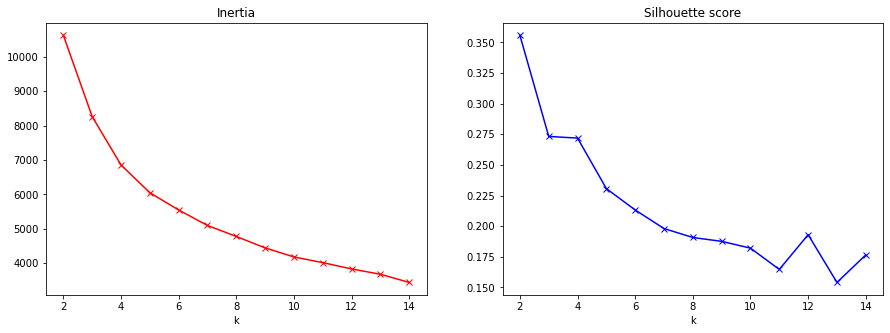

In [8]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

## User-defined values

In [9]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

# Fit and classify using k-means

In [10]:
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(df)
print_classification_counts(labels)

Class 0 (yellow): 75 (45.45%)
Class 1 (red): 8 (4.85%)
Class 2 (cyan): 26 (15.76%)
Class 3 (orange): 56 (33.94%)


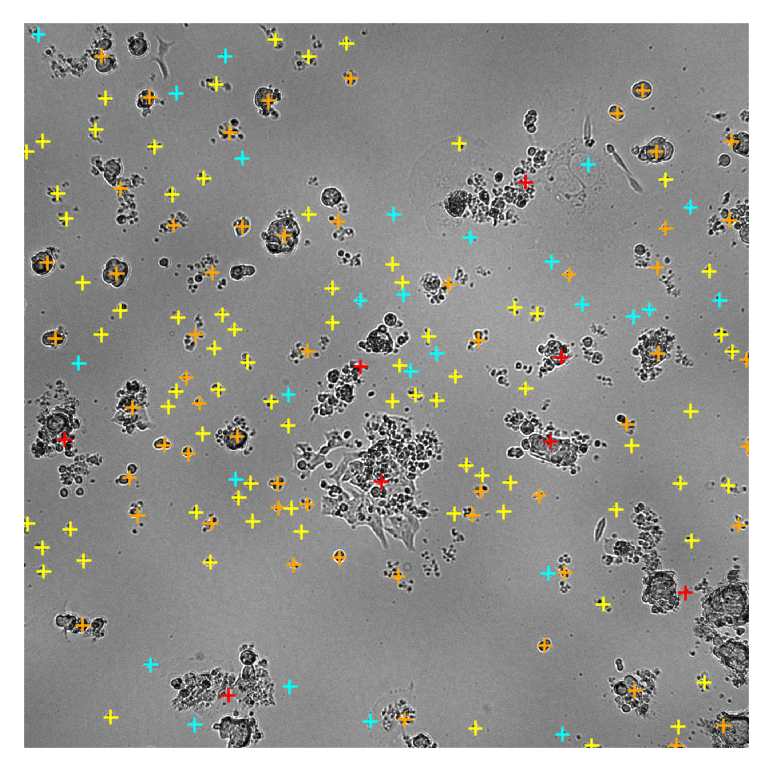

In [11]:
display_classifications(image_gray, df.index, labels)

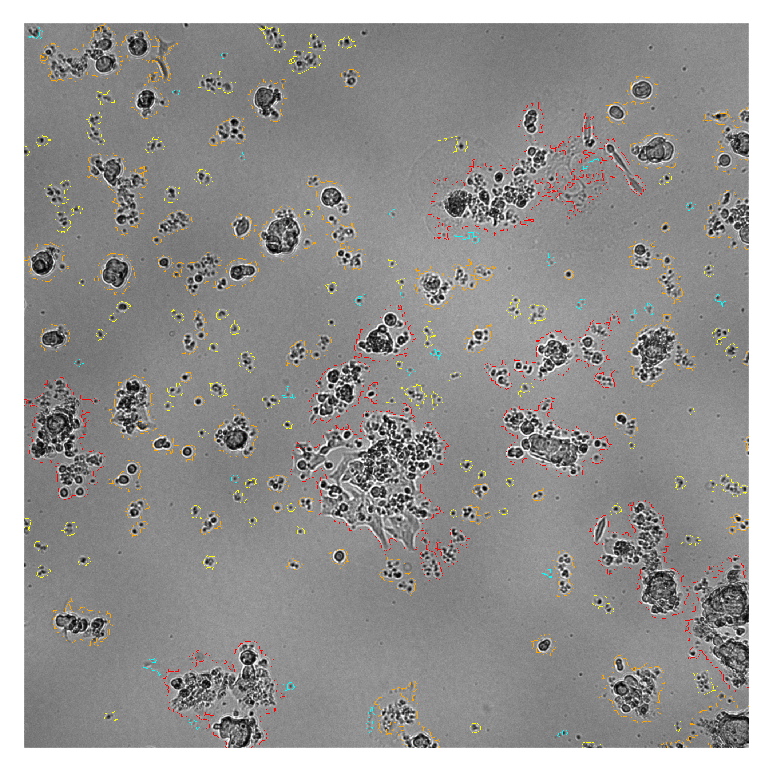

In [12]:
display_contours(image_gray, masks, labels)

In [13]:
# display_rois(image_gray, masks, labels)

# Visualize clusters with t-SNE

Unfortunately `sklearn` doesn't let us set a colormap here, so the colors aren't consistent.

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


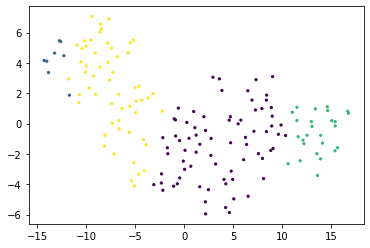

In [14]:
display_tsne(df)

# Classify whole image stack

In [15]:
gray_images = list(map(scale_image, image_stack[1::3]))
fluor_images_1 = image_stack[0::3]
fluor_images_2 = image_stack[2::3]

## Extract raw features in parallel

`get_mask_image` and `extract_features` are the most computationally expensive operations, and conveniently are also very easy to parallelize.

This cuts down runtime by ~50%. Note that `tqdm` tracks process initiation, not completion, but this is a cheap and easy way to track progress.

In [16]:
def ef_parallel(image_gray):
    mask_image = get_mask_image(image_gray, 'params_gray_mask.yml')
    df, masks = extract_features(image_gray, mask_image)
    return mask_image, df, masks

In [17]:
result = Parallel(n_jobs=cpu_count())(delayed(ef_parallel)(ig) for ig in tqdm(gray_images))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [4:17:07<00:00, 164.12s/it]


## Process features, cluster using k-means, extract fluorescence data

This expects that the models have been trained in the cells above - we'll re-transform the first image but that's okay.

Image 0:


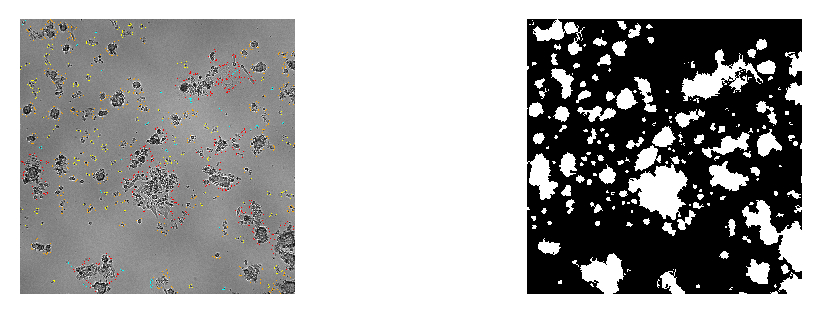

Image 5:


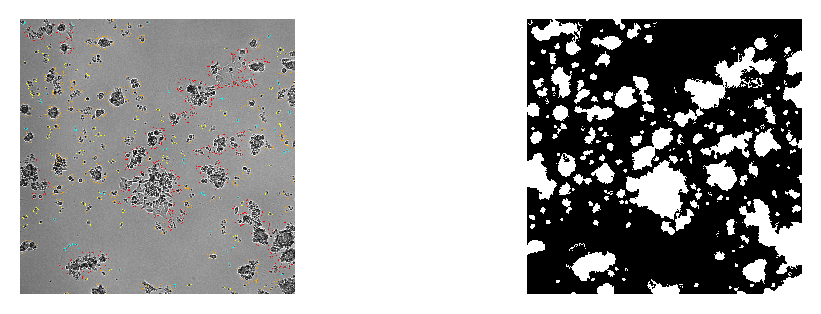

Image 10:


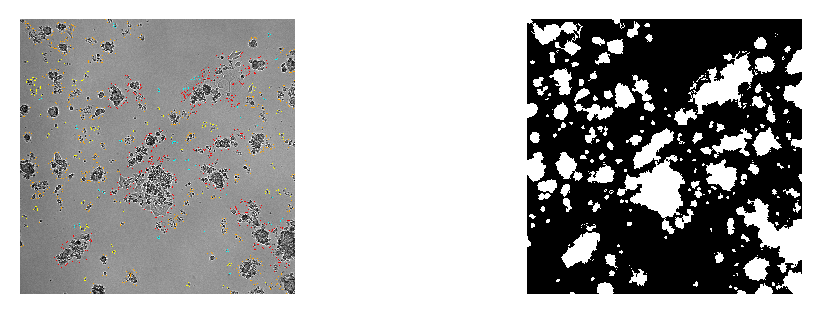

Image 15:


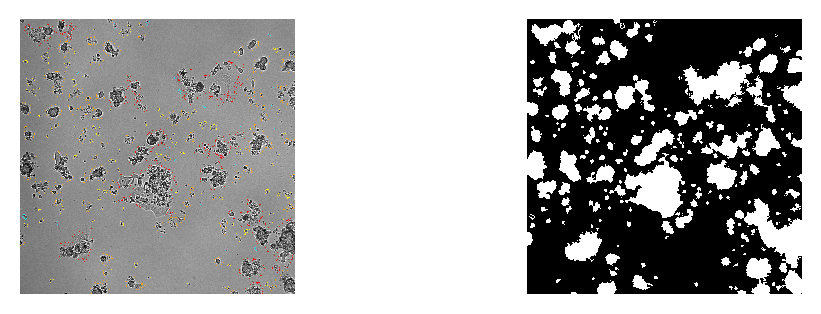

Image 20:


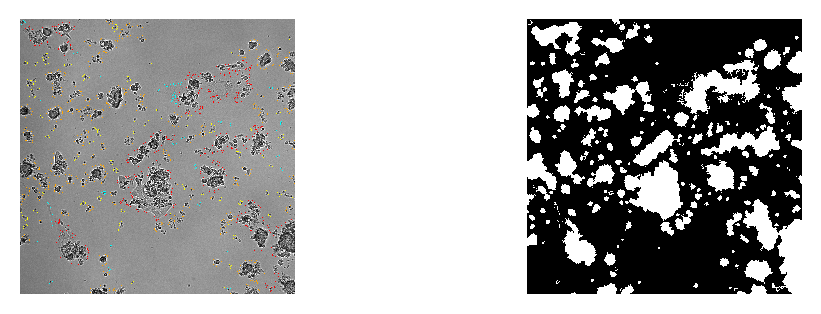

Image 25:


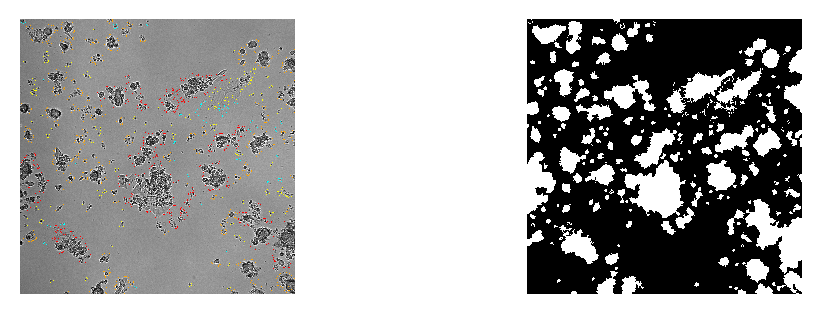

Image 30:


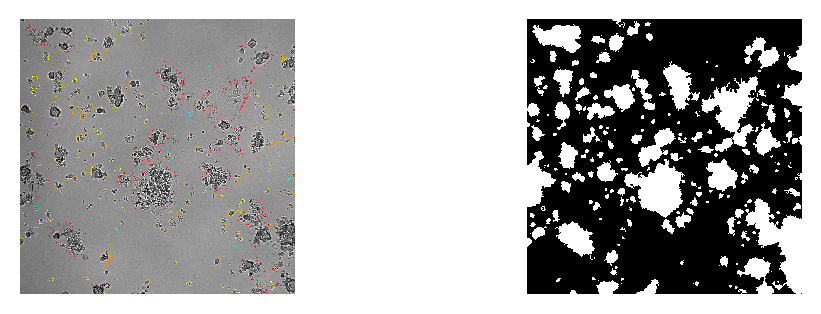

Image 35:


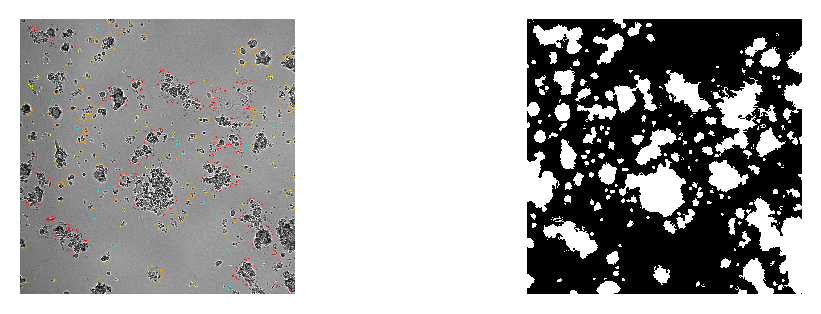

Image 40:


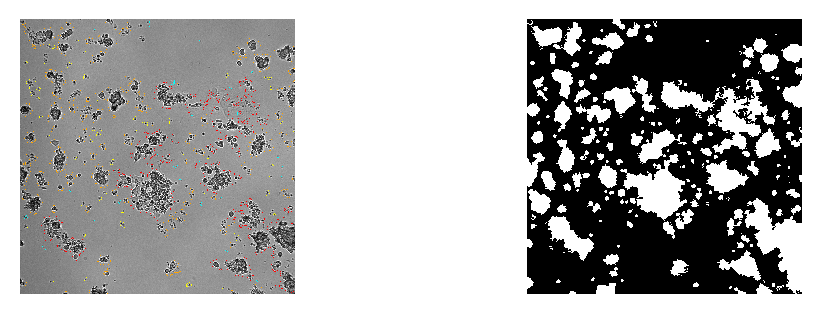

Image 45:


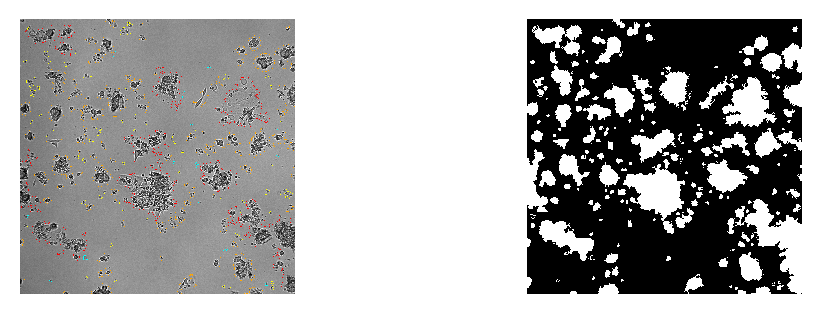

Image 50:


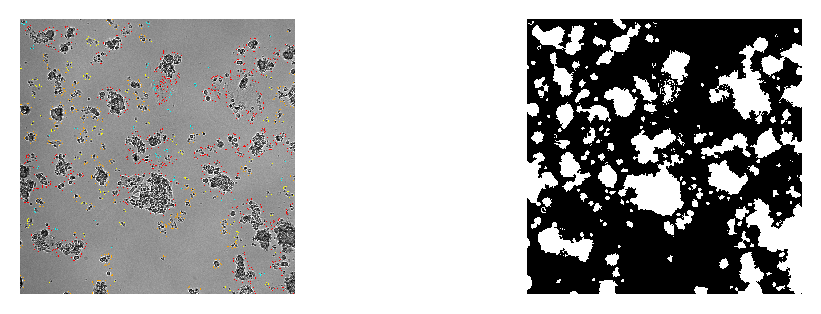

Image 55:


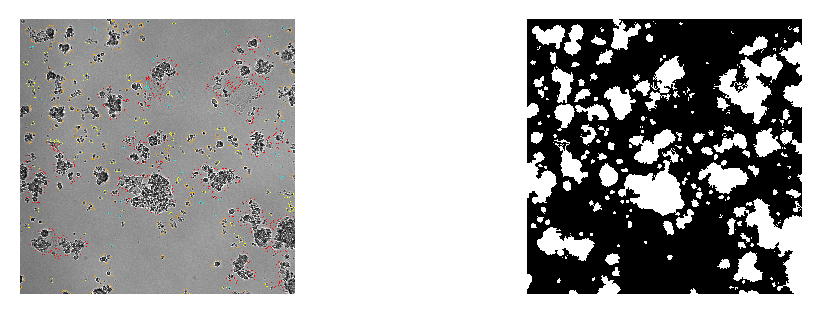

Image 60:


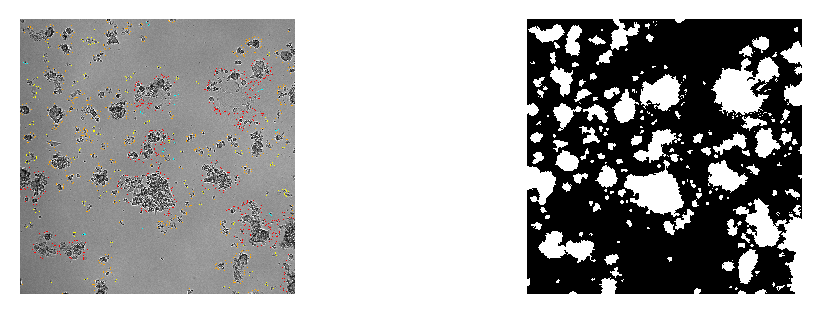

Image 65:


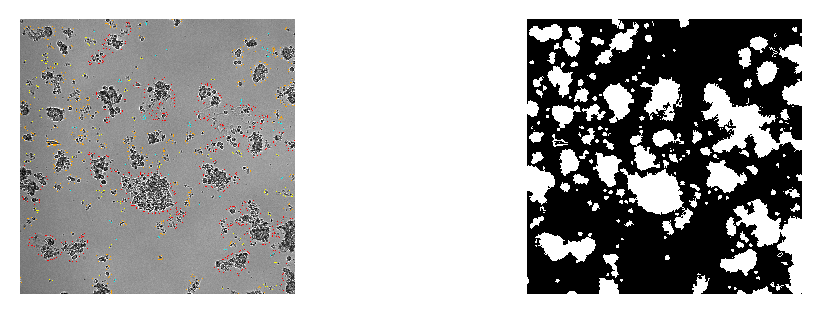

Image 70:


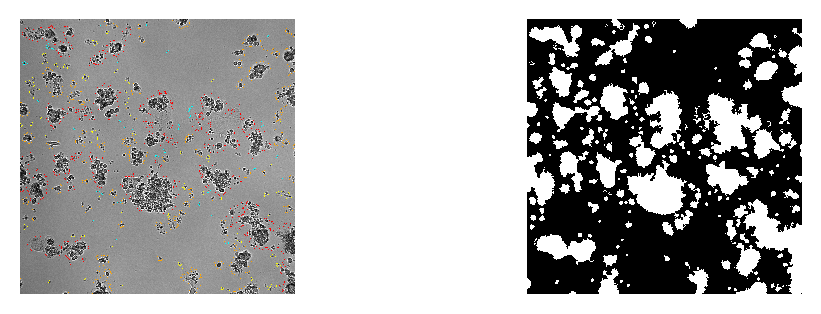

Image 75:


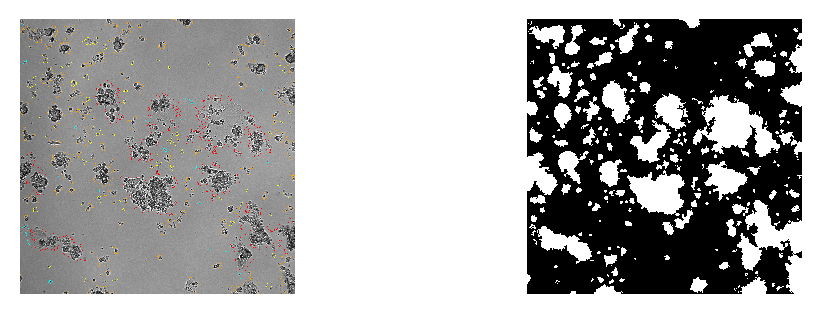

Image 80:


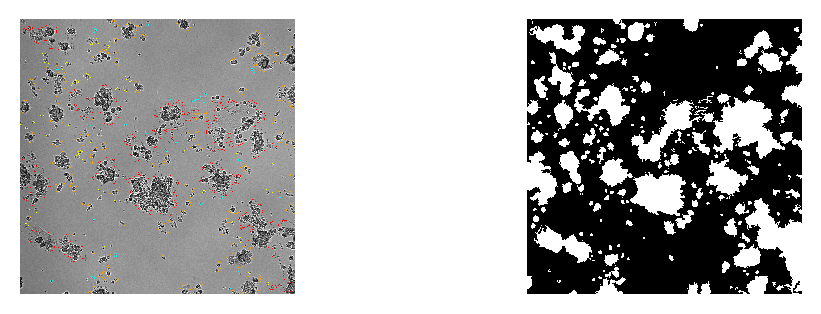

Image 85:


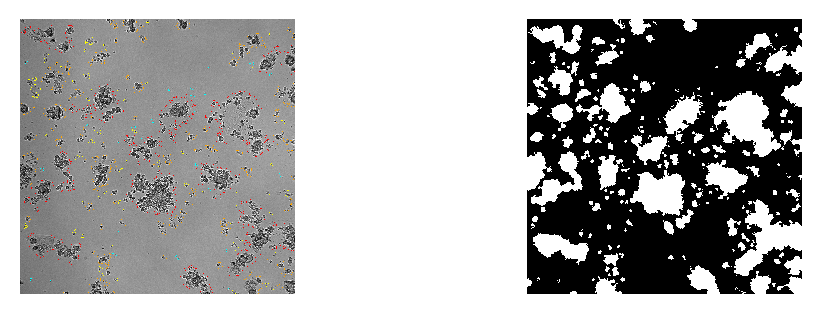

Image 90:


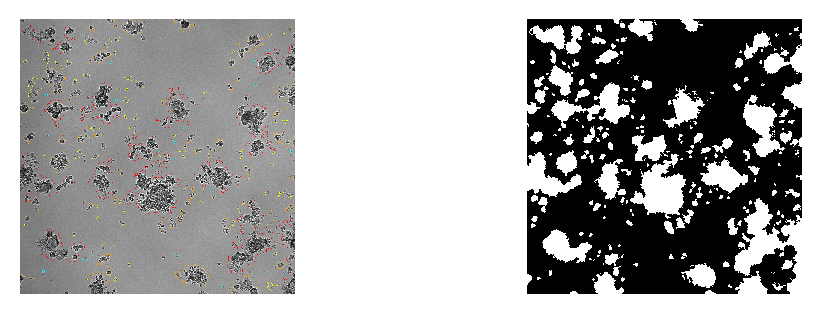

In [18]:
counts = []
intensities_1 = []
intensities_2 = []

max_1 = np.array(fluor_images_1).max()
max_2 = np.array(fluor_images_2).max()

for i in range(len(result)):
    mask_image, df, masks = result[i]

    # Preprocess features
    df = pd.DataFrame(pca.transform(scaler.transform(df.to_numpy(dtype=np.float64))),
                      index=df.index)
    
    # Cluster using k-means
    labels = kmeans.predict(df)
    
    # Count classes
    counts += [[a[1] for a in sorted(Counter(labels).items(), key=lambda a: a[0])],]

    # Extract fluorescence data
    # WARNING: This step is extremely slow, but don't try to parallelize this -
    # the many mask images will gobble up swap space
    i1 = np.zeros((k, max_1))
    i2 = np.zeros((k, max_2))
    for j in range(k):
        combined_mask = np.bitwise_or.reduce(masks[np.where(labels==j)], axis=0)
        # do some hacky arithmetic here to ignore regions outside the mask
        combined_mask = np.int16(combined_mask) * 2 - 1
        c1 = Counter(((combined_mask * (np.int16(fluor_images_1[i])+5))-5).flatten())
        c2 = Counter(((combined_mask * (np.int16(fluor_images_2[i])+5))-5).flatten())
        i1[j] = [c1[a] for a in range(max_1)]
        i2[j] = [c2[a] for a in range(max_2)]
    intensities_1 += [i1,]
    intensities_2 += [i2,]
    
    # Display sanity check images
    if i % 5 == 0:
        print("Image %i:" % i)
        contour_image = display_contours(gray_images[i], masks, labels, ret_image=True)
        display_image_array([contour_image, mask_image], columns=2, dpi=200)

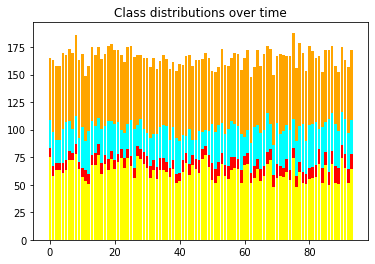

In [19]:
bottom = np.zeros(len(counts))
class_counts = np.array(counts).T

for i in range(len(class_counts)):
    c = class_counts[i]
    plt.bar(range(len(c)), c, bottom=bottom, color=colormap.colors[i])
    plt.title("Class distributions over time")
    bottom += c

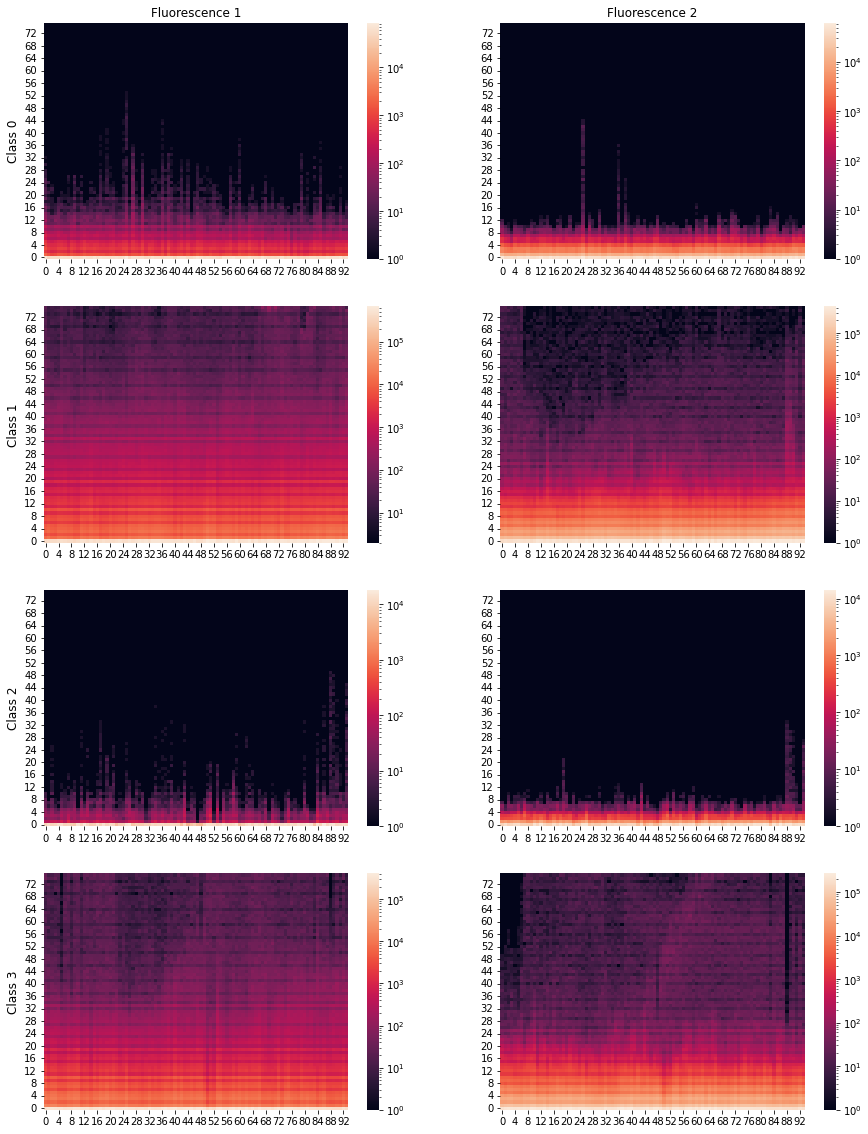

In [20]:
intensities_1 = np.array(intensities_1)
intensities_2 = np.array(intensities_2)

fig, axs = plt.subplots(intensities_1.shape[1], 2, figsize=(15,20))
axs[0,0].set_title("Fluorescence %i" % 1)
axs[0,1].set_title("Fluorescence %i" % 2)

for i in range(intensities_1.shape[1]):
    # Adding 1 here is a hacky trick to avoid taking the log of 0
    sns.heatmap(intensities_1[:,i,:].T+1, ax=axs[i,0], norm=matplotlib.colors.LogNorm())
    sns.heatmap(intensities_2[:,i,:].T+1, ax=axs[i,1], norm=matplotlib.colors.LogNorm())
    axs[i,0].set_ylabel(("Class %i" % i), size='large')
    axs[i,0].invert_yaxis()
    axs[i,1].invert_yaxis()

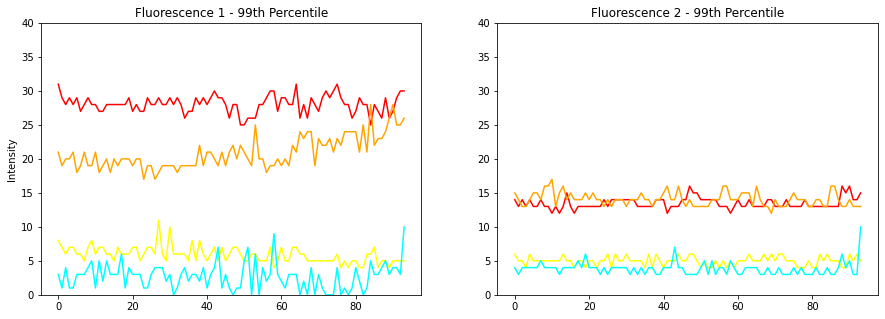

In [21]:
percentile = 99

def get_perc_value_from_counts(counts, percentile):
    pidx = int(sum(counts) * percentile / 100)
    for i in range(len(counts)):
        if pidx > counts[i]:
            pidx -= counts[i]
        else:
            return i

perc_values_1 = np.zeros((len(intensities_1), k))
for i in range(len(intensities_1)):
    perc_values_1[i] = list(map(get_perc_value_from_counts, intensities_1[i], [percentile]*k))
perc_values_1 = perc_values_1.T

perc_values_2 = np.zeros((len(intensities_2), k))
for i in range(len(intensities_2)):
    perc_values_2[i] = list(map(get_perc_value_from_counts, intensities_2[i], [percentile]*k))
perc_values_2 = perc_values_2.T

plt.figure(figsize=(15, 5))
for i in range(len(perc_values_1)):
    plt.subplot(1,2,1)
    plt.plot(perc_values_1[i], color=colormap.colors[i])
    plt.title("Fluorescence 1 - %ith Percentile" % percentile)
    plt.ylabel("Intensity")
    plt.ylim(0, 40)

    plt.subplot(1,2,2)
    plt.plot(perc_values_2[i], color=colormap.colors[i])
    plt.title("Fluorescence 2 - %ith Percentile" % percentile)
    plt.ylim(0, 40)
plt.show()